DNA HotEncoder Difussion adapted from the Annotated diffusion notebook (https://huggingface.co/blog/annotated-diffusion)


Training is taking a lot wihout A100 GPU

-Non bit diffusion implementation  


Contributions   
Lucas Ferreira da Silva  
Luca Pinello
Zach Nussbaum

Tasks

---


 - Transfer task annotation from the diffusion notebook 
 - Reimplement the cell conditional diffusion
 - Fix the architecure to lower the metrics 
 - Is this the best metric (kl motifs absence and presence)?




---
 - remove the comments from OVERFIT to train the model using only one sequence
 - The model is learning since I'm not enforcing the intermediarie steps follow the -1 / + 1 hotencoding constraint. In the last diffusion steps we can notice this convergence (only one 1(+1) and 3 (-1))



# Installs and Downloads

In [1]:
#downloading data
!wget https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
#changing name
!mv   train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv.gz
#unpcaking 
!gunzip -d /train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv
#new seqs


--2022-10-16 21:54:56--  https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz [following]
--2022-10-16 21:54:56--  https://www.dropbox.com/s/raw/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2334e223af56eefff0acf68b7.dl.dropboxusercontent.com/cd/0/inline/Bu9ZsFhDqV3KHPcU1FAE5KR90BgdjO-AZ6hU3qy-eQw8tFcDy6T0cHGvAeyykqyWffVFLvTuNaSR_R-Fu-qjhfZKB_wiJY_fk-HcmFxeHkjiz2kFNMBdCd2LpkV7u6mGhBQM8wZ1yrhOAGnF3TpSWDFpn5ipN_nNOgeBtenomrupCg/file# [following]
--2022-10-16 21:54:58--  https://ucf2334e223af56eefff0acf68b7.dl.dropboxusercontent.com/cd/0/inli

# Importing

In [2]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import nn, einsum
import torch.nn.functional as F


import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image


%matplotlib inline


# Utils

In [3]:
nucleotides = ['A', 'C', 'T', 'G']

def one_hot_encode(seq, alphabet, max_seq_len):
    """One-hot encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(alphabet)))
    for i in range(seq_len):
        seq_array[i, alphabet.index(seq[i])] = 1
    return seq_array



def encode(seq, alphabet):
    """Encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros(len(alphabet))
    for i in range(seq_len):
        seq_array[alphabet.index(seq[i])] = 1
    
    return seq_array


def show_seq(dataloader_seq):
    for i_image in dataloader_seq:
      for image in i_image:
        image = image.numpy().reshape(4,200)
        print (image)
        plt.rcParams["figure.figsize"] = (20,1)
        pd_seq = pd.DataFrame(image)
        pd_seq.index = nucleotides
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0) 
        plt.show()

class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, seqs, c, transform=None):
        'Initialization'
        self.seqs = seqs
        self.c = c
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.seqs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.seqs[index]

        x = self.transform(image)

        y = self.c[index]

        return x, y
  
    



## Motif Metric

In [56]:
def sampling_to_metric():
  # Sampling regions using the trained  model
    final_sequences=[]
    for n_a in tqdm_notebook(range(20)): # generating 20*10 sequences
      #sampled_images = bit_diffusion.sample(batch_size = 4)
        sample_bs = 10
        sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(sample_bs)))
        random_classes = torch.zeros((sample_bs, len(cell_types)))
        random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()
        sampled_images = sample(model, classes=random_classes, image_size=image_size, batch_size=sample_bs, channels=1)
        sampled_images = sampled_images
        for n_b, x in enumerate(sampled_images):
            x = x[-1]
            #print(x.shape)
            seq_final = f'>seq_test_{n_a}_{n_b}\n' +''.join([nucleotides[s] for s in np.argmax(x.reshape(4,200), axis=0)]) 
            final_sequences.append(seq_final)



    save_motifs_syn = open('synthetic_motifs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()
    #Scan for motifs
    !gimme scan synthetic_motifs.fasta -p   JASPAR2020_vertebrates -g hg38 > syn_results_motifs.bed
    df_results_syn = pd.read_csv('syn_results_motifs.bed', sep='\t', skiprows=5, header=None)
    df_results_syn['motifs'] = df_results_syn[8].apply(lambda x: x.split( 'motif_name "')[1].split('"')[0]   )
    df_results_syn[0] = df_results_syn[0].apply(lambda x : '_'.join(  x.split('_')[:-1])    )
    df_motifs_count_syn = df_results_syn[[0,'motifs']].drop_duplicates().groupby('motifs').count()
    plt.rcParams["figure.figsize"] = (30,2)
    df_motifs_count_syn.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.show()

    return df_motifs_count_syn
    
# Not using the total number of motifs but the count of the occurence aka: percentage of the sequences with a given motif.
def compare_motif_list(df_motifs_a, df_motifs_b):
  # Using KL divergence to compare motifs lists distribution
    set_all_mot = set(df_motifs_a.index.values.tolist() + df_motifs_b.index.values.tolist())
    create_new_matrix = []
    for x in set_all_mot:
        list_in = []
        list_in.append(x) # adding the name
        if x in df_motifs_a.index:
            list_in.append(df_motifs_a.loc[x][0])
        else:
             list_in.append(1)
                
        if x in df_motifs_b.index:
            list_in.append(df_motifs_b.loc[x][0])
        else:
             list_in.append(1)
        
        create_new_matrix.append(list_in)    
  

    df_motifs = pd.DataFrame(create_new_matrix, columns=['motif', 'motif_a', 'motif_b'])
    
    df_motifs['motif_a'] = df_motifs['motif_a'] / df_motifs['motif_a'].sum()  
    df_motifs['motif_b'] = df_motifs['motif_b'] / df_motifs['motif_b'].sum()
    display(df_motifs) 
    kl_pq = rel_entr(df_motifs['motif_a'].values, df_motifs['motif_b'].values )
    return    np.sum(kl_pq)

Alternative Metric

---
  - Are our synthetic regulatory regions predicted as enhancers in a orthogonal model?  
  - Can we predict it? (This is a metric similar to the critical actor on a GAN but not forcing it during training or inference time  (we could!))  
 - https://github.com/khanhlee/bert-enhancer
 - https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-017-1878-3#Ack1

<img src='https://raw.githubusercontent.com/pinellolab/DNA-Diffusion/dna-diffusion/other_files/Predicting%20enhancers%20with%20deep%20convolutional%20neural%20networks%20_%20BMC%20Bioinformatics%20_%20Full%20Text.png'>

<img src='https://github.com/khanhlee/bert-enhancer/raw/main/figures/flowchart.png'>



# Diffusion

In [57]:
@torch.no_grad()
def p_sample(model, x, classes, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    #print (x.shape, 'x_shape')
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, classes=classes, time=t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, classes, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, x=img, classes=classes, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, classes, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, classes=classes, shape=(batch_size, channels, 4, image_size))






### schedule

In [58]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps, beta_end=0.005):
    beta_start = 0.0001

    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

### Foward diffusion


In [59]:

# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )   

    #print  (sqrt_alphas_cumprod_t , sqrt_one_minus_alphas_cumprod_t , t)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise



### Loss

In [60]:
def p_losses(denoise_model, x_start, t, y, noise=None, loss_type="l1"):   # 
    if noise is None:
        noise = torch.randn_like(x_start) #  guass noise 
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise) #this is the auto generated noise given t and Noise
    # print('max_q_sample', x_noisy.max(), 'mean_q_sample',x_noisy.mean() )
    predicted_noise = denoise_model(x_noisy, t, y)   # this is the predicted noise given the model and step t
    # print('max_predicted', x_noisy.max(), 'mean_predicted',x_noisy.mean() )

    # #predicted is ok (clipped)
    # print ('predited inside loss')
    # print (predicted_noise)
    # print ('this is the noise generated by the p_losses')
    # print (noise)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        # print (noise.shape, 'noise' )
        # print (predicted_noise.shape, 'pred') 
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Models

### Simple CNND2

In [61]:

class ResBlock(nn.Module):

    """
    Iniialize a residual block with two convolutions followed by batchnorm layers
    """
    def __init__(self, in_size:int, hidden_size:int, out_size:int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, hidden_size, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, out_size, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(hidden_size)
        self.batchnorm2 = nn.BatchNorm2d(out_size)

    def convblock(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        return x
   
    """
    Combine output with the original input
    """
    def forward(self, x): return x + self.convblock(x) # skip connection






class ConvBlock_2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4 ,padding=2 ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 4,1,1
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        #print ('x', x.shape)
        x = self.conv1(x)
        #print ('conv1', x.shape)
        x = self.conv2(x)
        #print ('conv2', x.shape)
        #x = F.avg_pool2d(x, 2)
        
        return x



class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        


        self.res = nn.Sequential( ResBlock(1,2,1), ResBlock(1,2,1), ResBlock(1,2,1) , ResBlock(1,2,1))
        


        self.conv = nn.Sequential(
            ConvBlock_2d(in_channels=1, out_channels=2),
            nn.ReLU(),
            nn.BatchNorm2d(2),
            ConvBlock_2d(in_channels=2, out_channels=4),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            ConvBlock_2d(in_channels=4, out_channels=1),
            nn.BatchNorm2d(1)
            # ConvBlock_2d(in_channels=1, out_channels=1),
            # ConvBlock_2d(in_channels=1, out_channels=1),
            # ConvBlock_2d(in_channels=1, out_channels=1),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(800, 800),
            # nn.GELU(),
            nn.BatchNorm1d(800),     #ALWAYS BATCHNORM THIS CHANGES A LOT THE RESULTS
            # nn.Linear(400, 400),
            # nn.BatchNorm1d(400),
            # nn.GELU(),
            # nn.BatchNorm1d(400),
         
        )


        self.fc2 = nn.Sequential(
            nn.Linear(400, 800),
            # nn.GELU(),
            nn.BatchNorm1d(800),     #ALWAYS BATCHNORM THIS CHANGES A LOT THE RESULTS
            # nn.Linear(400, 400),
            # nn.GELU(),
            # nn.BatchNorm1d(400),
         
        )

        time_dim = 200 * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(100),
            nn.Linear(100, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        self.time_mlp_out = nn.Sequential(
            SinusoidalPositionEmbeddings(100),
            nn.Linear(100, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

    def forward(self, x, y):
        #print (x.shape, 'inside model x ')
        x_a = x.clone()
        # y_a = y.clone()
        x = self.res(x)
        
        #print ('to_full', x.shape)
    
        y_emb = self.time_mlp(y)
        # y_emb_out = self.time_mlp_out(y_a)
        
        x = x.view(-1,800)

        
        x_a = x.view(-1,800)
        x_a = self.fc(x_a)
        

        x = x + y_emb.view(-1,800) * x_a

        
        #x = self.fc2(x)
        #x = x + y_emb_out.view(-1,400) + x_a

        #x = torch.clip(x, min=-1, max=1) 
        x = x.view(-1,1,4,200)
        
        #x = x.view(-1,1,200,4)

        
        
        #print (x.shape)
        #The cliping is working already checked
        return x



In [62]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### UNET and UTILS

In [63]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

def l2norm(t):
    return F.normalize(t, dim = -1)

# small helper modules


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d



class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# positional embeds

class LearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with learned sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

    
class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(self, dim, dim_out, *, num_classes, class_embed_dim, time_emb_dim = None, groups = 8):
        super().__init__(dim=dim+class_embed_dim, dim_out=dim_out, time_emb_dim=time_emb_dim, groups=groups)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)
      

  
    def forward(self, x, time_emb=None, c=None, mask=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])

        if mask:
            # mask classes so we can jointly train condtioned and unconditioned
            # masking with 1e-9 like we do in Transformers
            emb_c = emb_c.masked_fill(mask, 1e-9)

        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

# bit diffusion class

def log(t, eps = 1e-20):
    return torch.log(t.clamp(min = eps))

def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))

def beta_linear_log_snr(t):
    return -torch.log(expm1(1e-4 + 10 * (t ** 2)))

def alpha_cosine_log_snr(t, s: float = 0.008):
    return -log((torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps = 1e-5) # not sure if this accounts for beta being clipped to 0.999 in discrete version

def log_snr_to_alpha_sigma(log_snr):
    return torch.sqrt(torch.sigmoid(log_snr)), torch.sqrt(torch.sigmoid(-log_snr))



class Unet_lucas(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        dim_mults=(1, 2, 4),
        channels = 1,
        resnet_block_groups = 8,
        learned_sinusoidal_dim = 16,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        # determine dimensions

        channels =1
        self.channels = channels

        input_channels = channels * 2
        #print ('input channels',input_channels)




        init_dim = default(init_dim, dim)
        print (init_dim, 'init_dim')
        #self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3) # original
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7,7), padding = 3)

        #print (self.init_conv)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        #print (dims)


        in_out = list(zip(dims[:-1], dims[1:]))
        #print (in_out)
        block_klass = partial(ResnetBlockClassConditioned, groups=resnet_block_groups,
                             num_classes=num_classes, class_embed_dim=class_embed_dim)

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        #self.final_res_block = block_klass(1, dim, time_emb_dim = time_dim)

        #self.final_conv = nn.Conv2d(dim, channels, 1)
        self.final_conv = nn.Conv2d(dim, 1, 1)
        #print('self.final_conv' , self.final_conv)


        print ('final',dim, channels, self.final_conv)

    def forward(self, x, time, classes, x_self_cond = None):
        #print (x.shape ,'in_shape')
        x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
        x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        #print ('init_conv', x.shape)
        r = x.clone()

        t = self.time_mlp(time)
        if classes is None:
            classes = torch.zeros((x.shape[0], self.num_classes))
            context_mask = torch.ones((x.shape[0]))


        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, classes)
            h.append(x)

            x = block2(x, t, classes)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, classes)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, classes)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t, classes)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t, classes)
            x = attn(x)

            x = upsample(x)

        
        #print('x torch_after_upsamples',x.shape)

        x = torch.cat((x, r), dim = 1)
        #print('x tochcat', x.shape)

        x = self.final_res_block(x, t, classes)
        #print(self.final_res_block)
        #print('x from res_block before final_conv',x.shape)
        #print (self.final_conv(x).shape)
        x = self.final_conv(x)
        #print ('FINAL X', x.shape)
        return x

# Loading data and generating fasta files and motifs

In [64]:
#Loading Dataset
df = pd.read_csv("train_all_classifier_WM20220916.csv", sep="\t")
df.head()
df = df.sample(1000) # Using 4000k cells

In [65]:
#Save the Fasta to compute the motifs in the training sequences
save_fasta= open('fastq_train_component.fasta', 'w')
write_fasta_component = '\n'.join(df[['Unnamed: 0', 'raw_sequence', 'component']].apply(lambda x : f'>{x[0]}_component_{x[2]}\n{x[1]}', axis=1).values.tolist())
save_fasta.write(write_fasta_component)
save_fasta.close()

In [66]:

def generate_heatmap_motifs(df_results_seq_matrix):
  print ('Generating Matrix....')
  all_motifs =  { m_init:0 for m_init in set(df_results_seq_matrix['motifs'].values)}
  sequen_dic = {seq_init:all_motifs.copy()  for seq_init in  set(df_results_seq_matrix[0].values)  }


  for k,v in df_results_seq_matrix.groupby([0, 'motifs']):
    sequen_dic[k[0]][k[1]] =   v.count()[0]

  df_motifs_matrix = pd.DataFrame(sequen_dic).T
  df_motifs_matrix['comps'] = [int(comp_i.split('_')[-1]) for comp_i in  df_motifs_matrix.index.values]
  df_motifs_matrix = df_motifs_matrix.sort_values(['comps'])
  comp_rows =  df_motifs_matrix['comps'].values
  del df_motifs_matrix['comps']
  df_motifs_matrix

  pal_hls = sns.hls_palette(16).as_hex()
  {e:c for  e,c in  enumerate(pal_hls[:])}
  sns.clustermap( df_motifs_matrix,cmap='Reds', row_cluster=True, row_colors = [pal_hls[c_extract] for c_extract in  comp_rows])
  plt.show()


Computing Motifs....
scanning: 100%|█████████████████████| 1000/1000 [00:11<00:00, 83.98 sequences/s]
Generating Matrix....


/fsx/home-zanussbaum/DNA-Diffusion/env/lib64/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


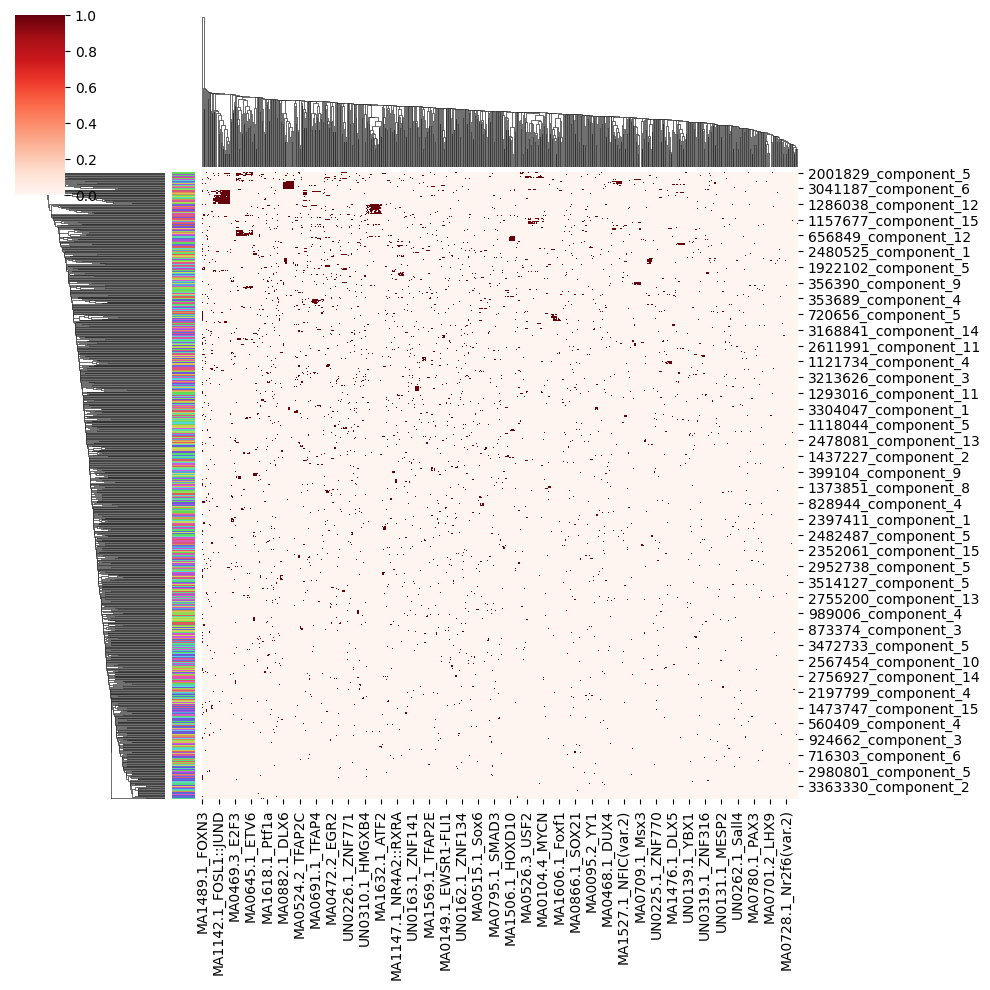

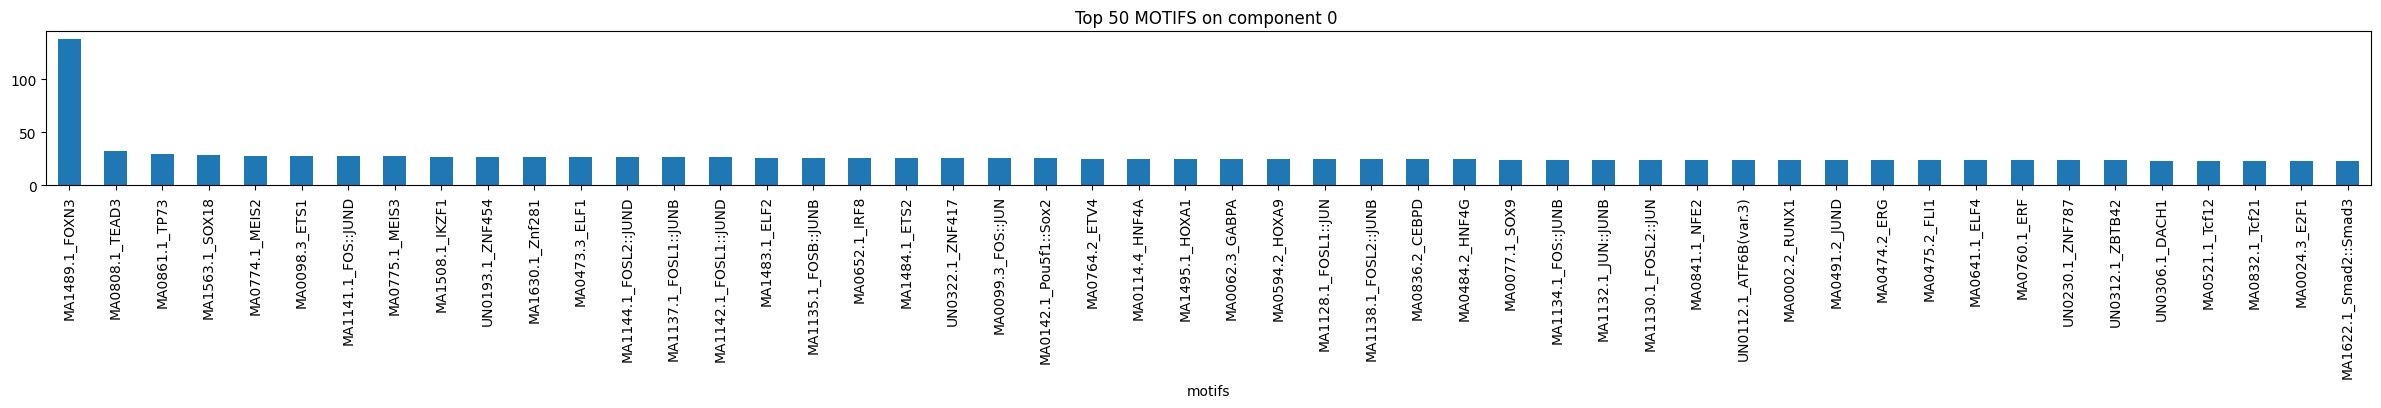

In [67]:
def motifs_from_fasta(fasta):
    print ('Computing Motifs....')
    !gimme scan $fasta -p  JASPAR2020_vertebrates -g hg38 > train_results_motifs.bed
    df_results_seq_guime = pd.read_csv('train_results_motifs.bed', sep='\t', skiprows=5, header=None)
    df_results_seq_guime['motifs'] = df_results_seq_guime[8].apply(lambda x: x.split( 'motif_name "'    )[1].split('"')[0]   )
    generate_heatmap_motifs(df_results_seq_guime)

    df_results_seq_guime[0] = df_results_seq_guime[0].apply(lambda x : '_'.join(  x.split('_')[:-1])    )
    df_results_seq_guime_count_out = df_results_seq_guime[[0,'motifs']].drop_duplicates().groupby('motifs').count()
    plt.rcParams["figure.figsize"] = (30,2)
    df_results_seq_guime_count_out.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.title('Top 50 MOTIFS on component 0 ')
    plt.show()
    return df_results_seq_guime_count_out

# df_results_seq_guime_count wil be used to compute the motifs distances
df_results_seq_guime_count = motifs_from_fasta('fastq_train_component.fasta')

In [68]:
dna_alphabet = ['A', 'C', 'T', 'G']
x_train_seq = np.array([one_hot_encode(x, dna_alphabet, 200) for x in df['raw_sequence'] if 'N' not in x ])
X_train = x_train_seq
X_train = np.array([x.T.tolist()  for x in X_train])
X_train[X_train == 0] = -1
X_train.shape

(1000, 4, 200)

In [69]:
cell_types = sorted(list(df.component.unique()))

In [70]:
x_train_cell_type = F.one_hot(torch.from_numpy(df["component"].to_numpy()), len(cell_types))

In [71]:
x_train_cell_type.shape

torch.Size([1000, 16])

In [72]:
tf = T.Compose([T.ToTensor()])
batch_size = 64
seq_dataset = SequenceDataset(seqs=X_train, c=x_train_cell_type, transform=tf)
train_dl = DataLoader(seq_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

## OVERFIT

In [73]:
# #Case want to test overfiiting (1500epochs)
# X_OVERFIT = np.array(X_train[0].tolist() * 200).reshape(-1,4,200)
# X_train = X_OVERFIT

# Train initialize and Training loop

In [74]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps, beta_end=0.05)
#betas = cosine_beta_schedule(timesteps=timesteps,  s=0.0001 )


# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
#sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) 



# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

0


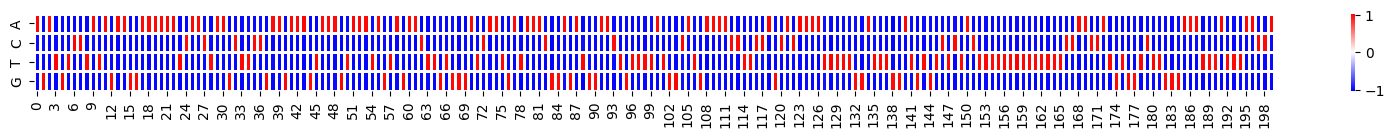

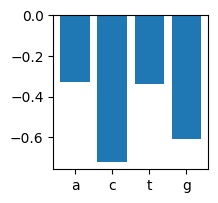

10


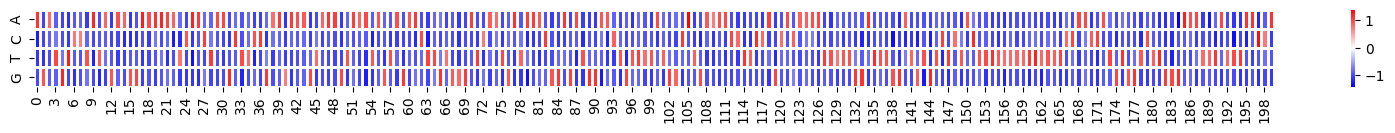

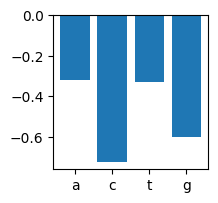

20


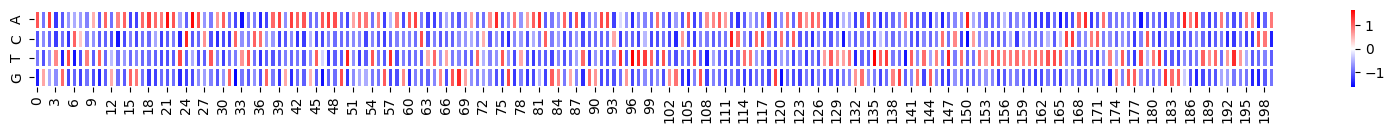

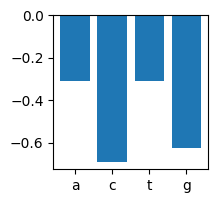

30


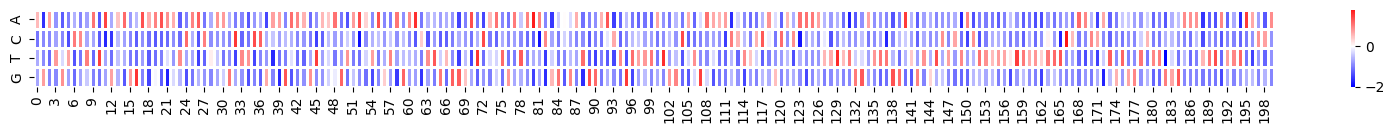

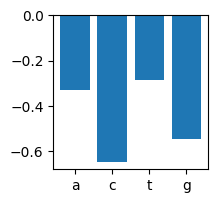

40


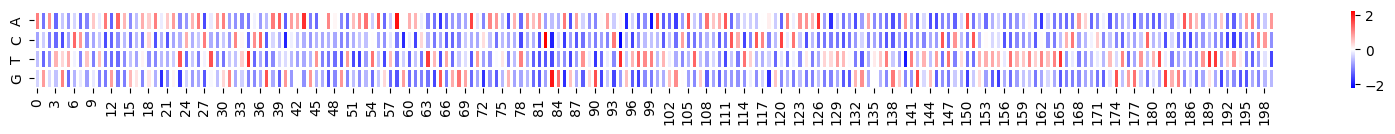

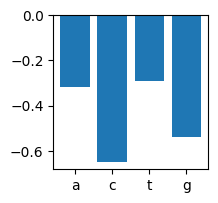

50


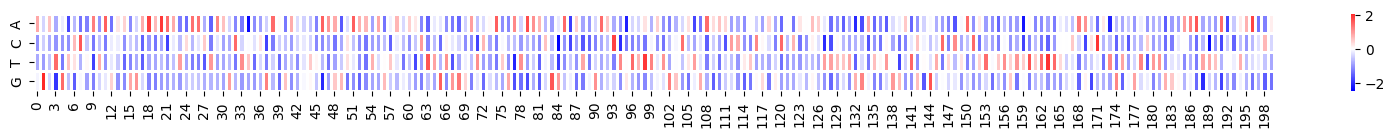

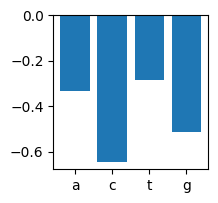

60


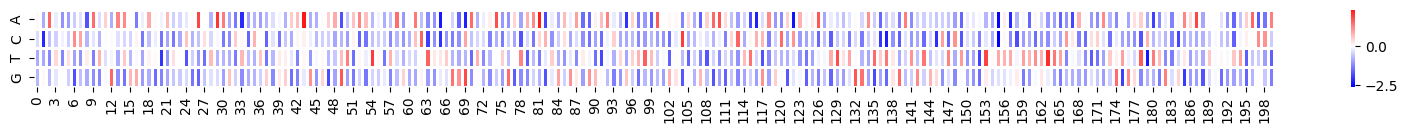

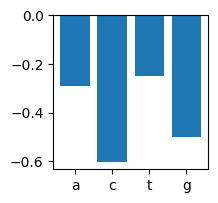

70


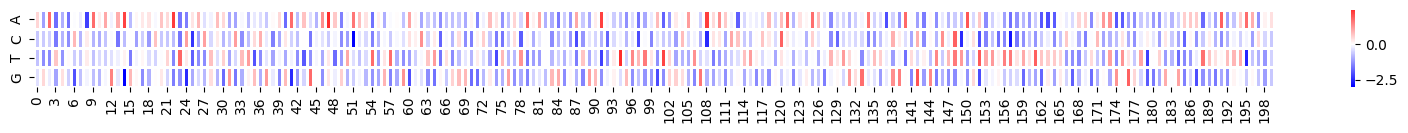

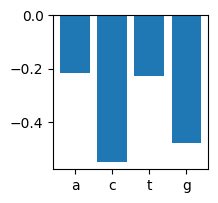

80


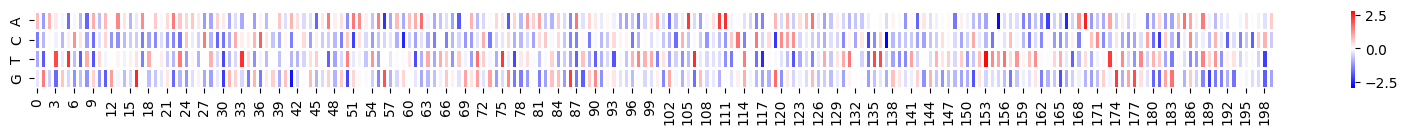

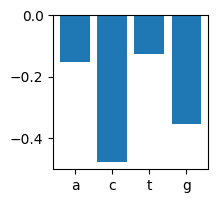

90


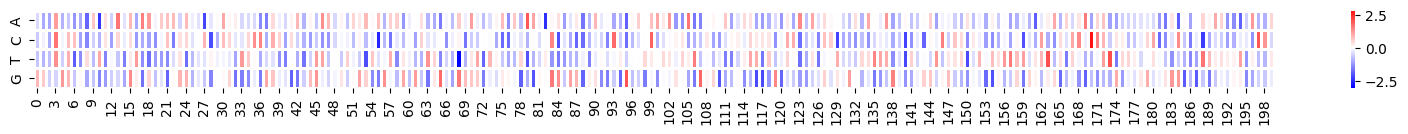

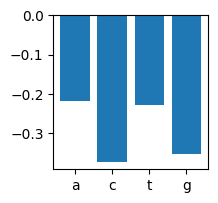

100


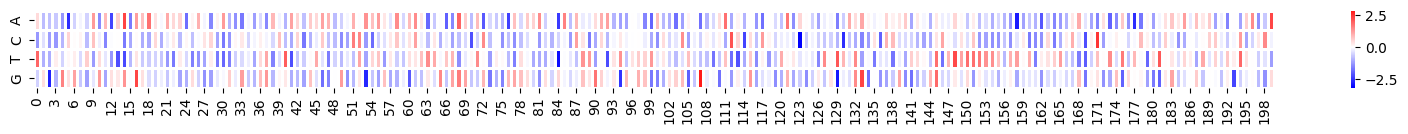

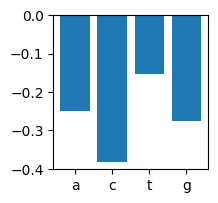

110


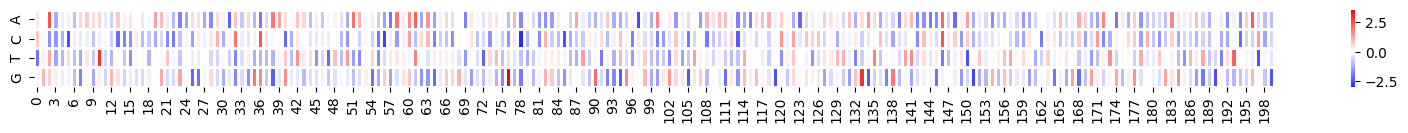

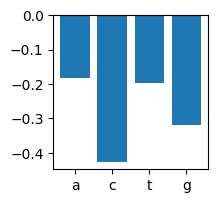

120


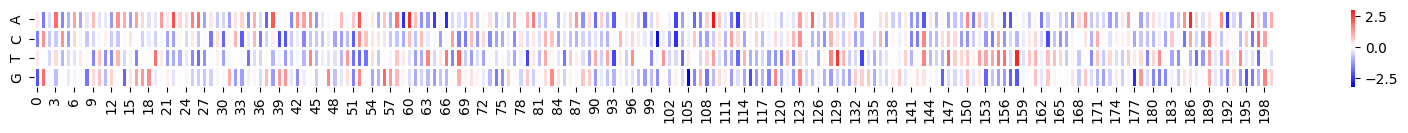

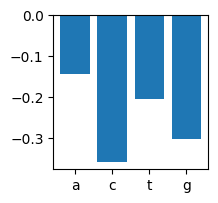

130


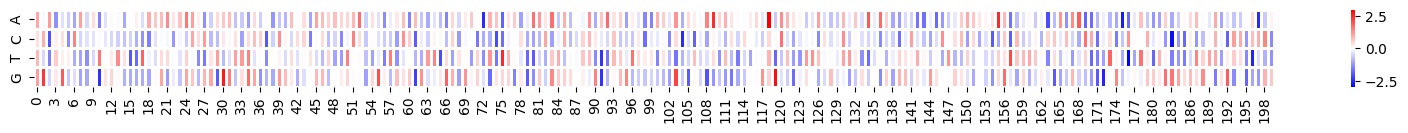

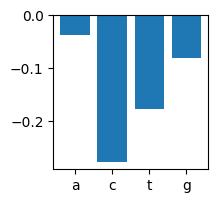

140


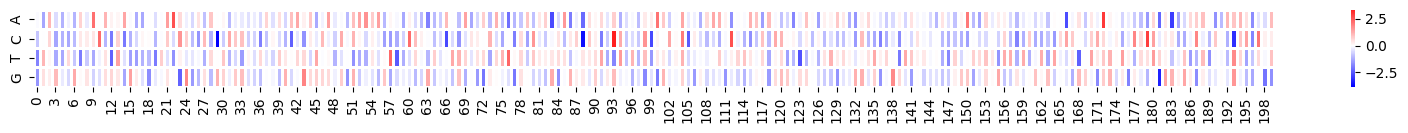

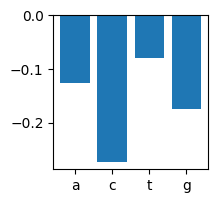

150


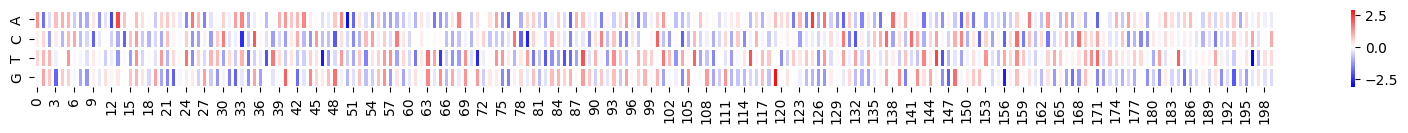

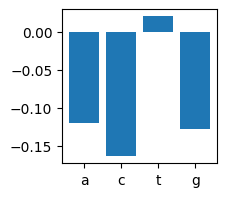

160


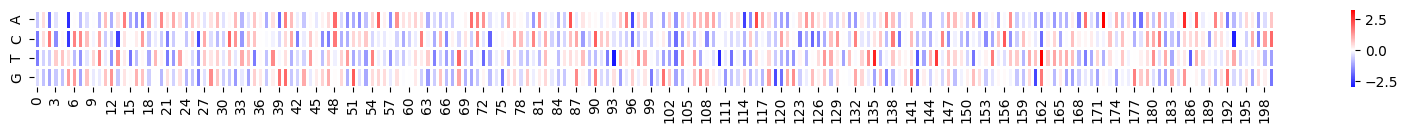

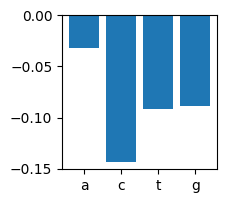

170


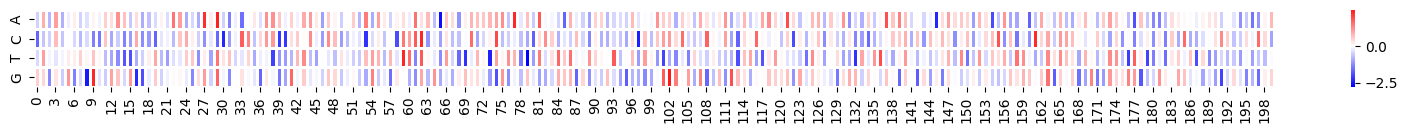

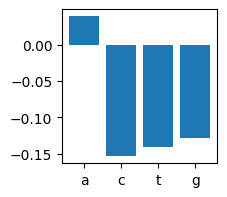

180


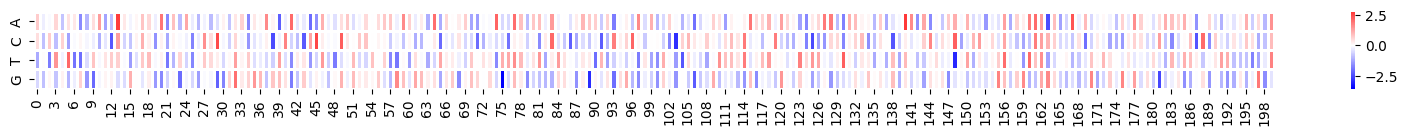

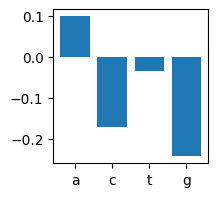

190


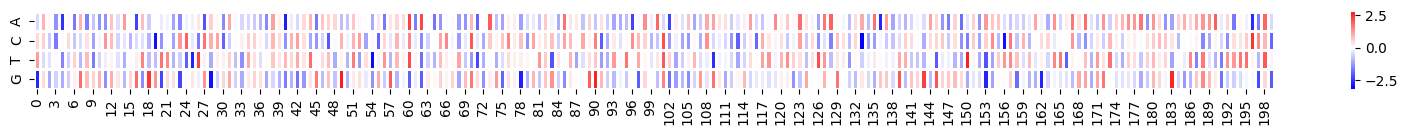

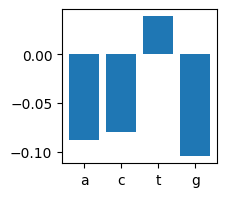

In [75]:
#Ploting images for a  foward pass example
for img_x_show, y in train_dl:
  
  for i in range(0,timesteps):
    if (i % 10) == 0:
      print (i)
      image_use = q_sample(img_x_show[0], t=torch.tensor([i]))
      image_use_numpy = image_use.numpy()
      
      plt.rcParams["figure.figsize"] = (20,1)
      pd_seq = pd.DataFrame(image_use_numpy.reshape(4,200))
      
      pd_seq.index = nucleotides
      sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0) 
      plt.show()
      plt.rcParams["figure.figsize"] = (2,2)

      plt.bar(['a', 'c', 't', 'g'],pd_seq.mean(1).T)
      plt.show()


  break


In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [77]:
torch.cuda.empty_cache()

In [78]:

print (device)
image_size = 200
channels = 1





model = Unet_lucas(

    dim = 200,
        channels = 1,
    dim_mults = (1,2,4),
    resnet_block_groups = 1,
    num_classes=len(cell_types)


).cuda()

#model = Classifier() # 2d conv

model.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

cuda
200 init_dim
final 200 1 Conv2d(200, 1, kernel_size=(1, 1), stride=(1, 1))


  0%|          | 0/10000 [00:00<?, ?it/s]

 Epoch 0 Loss: 0.3271855115890503
 Epoch 10 Loss: 0.06287267804145813
saving


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

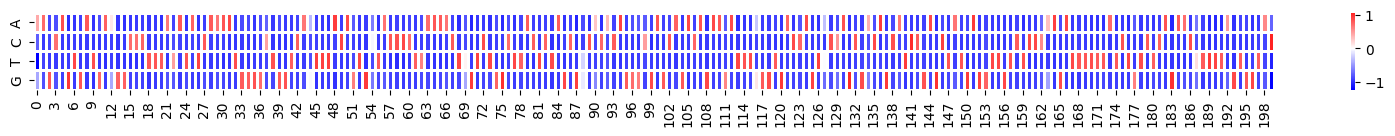

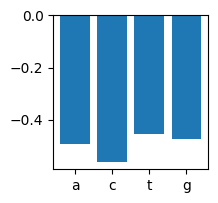

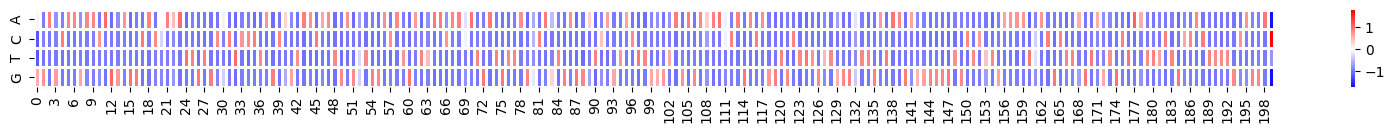

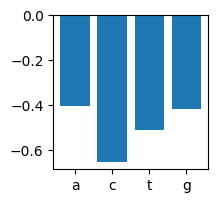

/tmp/ipykernel_33022/1885203364.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(20)): # generating 20*10 sequences


  0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

scanning: 100%|████████████████████| 4000/4000 [00:14<00:00, 276.39 sequences/s]


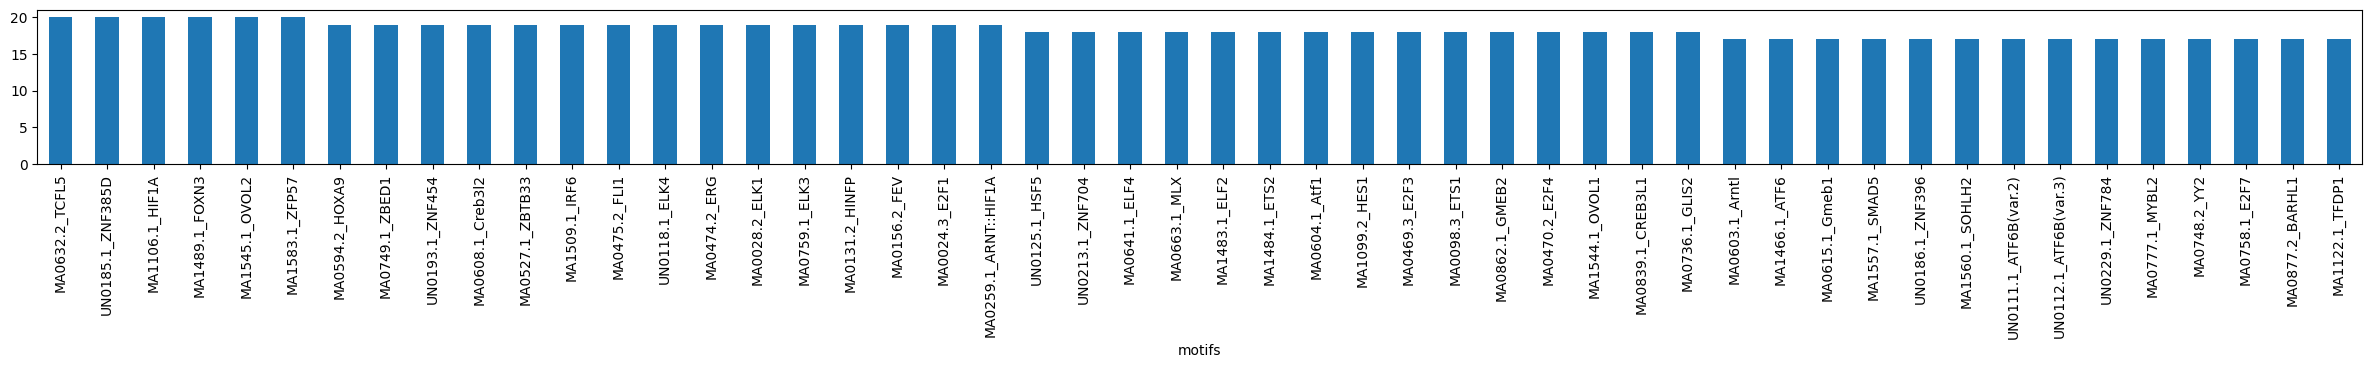

,motif,motif_a,motif_b
0,MA0691.1_TFAP4,0.000677,0.001825
1,MA0698.1_ZBTB18,0.001353,0.001651
2,MA0595.1_SREBF1,0.000812,0.000435
3,MA1468.1_ATOH7,0.000947,0.000782
4,MA0162.4_EGR1,0.001489,0.001912
...,...,...,...
879,MA1122.1_TFDP1,0.002301,0.001738
880,MA0468.1_DUX4,0.000406,0.000782
881,MA1501.1_HOXB7,0.000947,0.000521
882,MA0059.1_MAX::MYC,0.002165,0.001304


0.16145597816083918 KL
 Epoch 20 Loss: 0.05265238136053085
saving


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

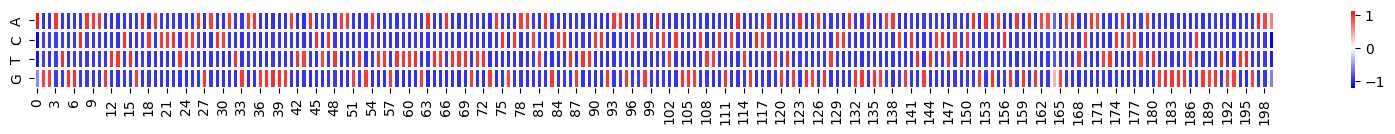

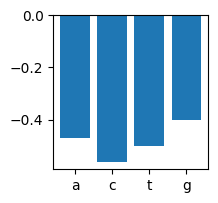

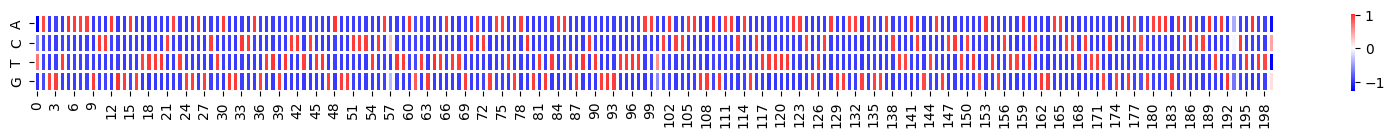

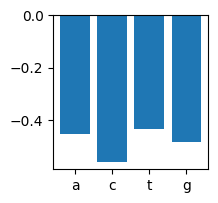

/tmp/ipykernel_33022/1885203364.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(20)): # generating 20*10 sequences


  0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

scanning: 100%|████████████████████| 4000/4000 [00:14<00:00, 274.42 sequences/s]


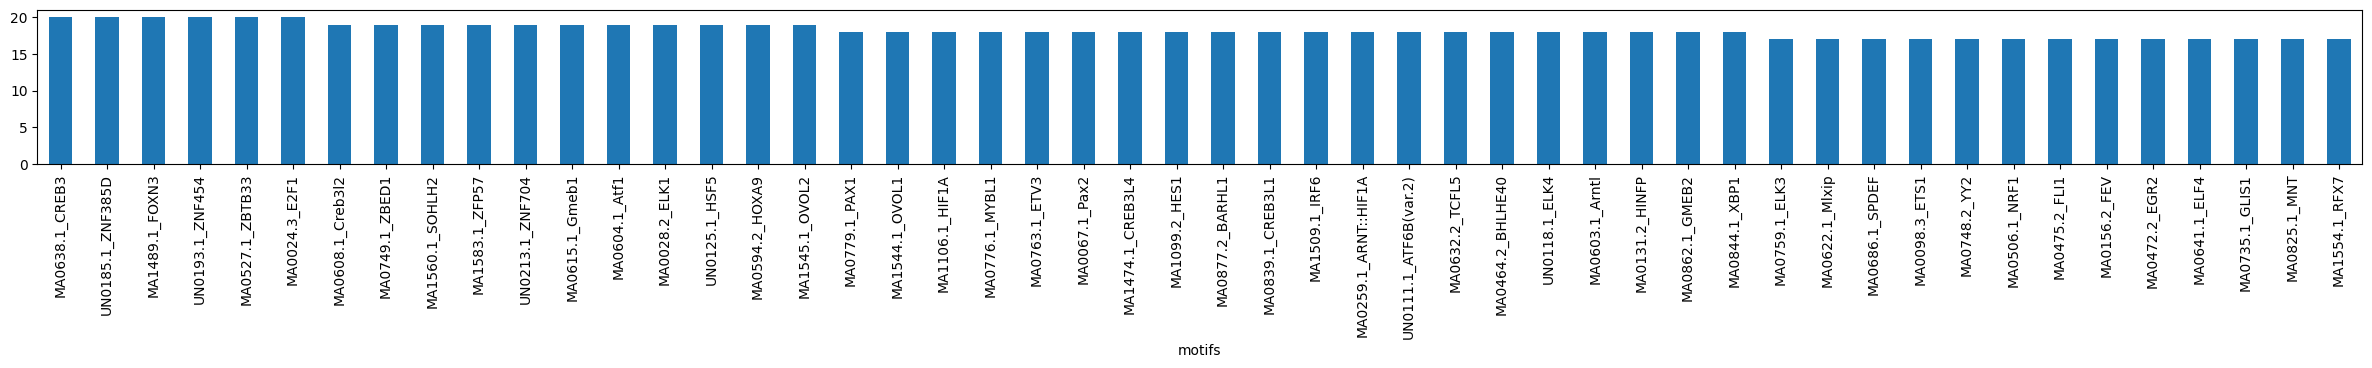

,motif,motif_a,motif_b
0,MA0691.1_TFAP4,0.001366,0.001825
1,MA0698.1_ZBTB18,0.000410,0.001651
2,MA0595.1_SREBF1,0.000819,0.000435
3,MA1468.1_ATOH7,0.001229,0.000782
4,MA0162.4_EGR1,0.001502,0.001912
...,...,...,...
879,MA1122.1_TFDP1,0.002048,0.001738
880,MA0468.1_DUX4,0.000410,0.000782
881,MA1501.1_HOXB7,0.000683,0.000521
882,MA0059.1_MAX::MYC,0.001912,0.001304


0.17155560939344192 KL
 Epoch 30 Loss: 0.033476572483778
saving


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

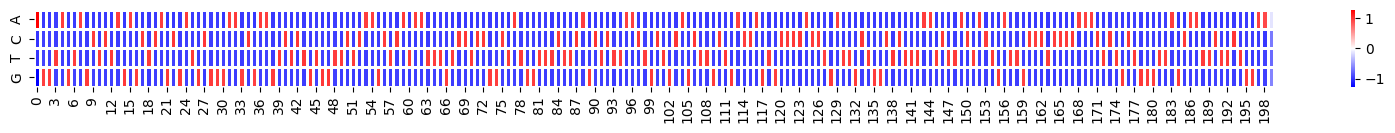

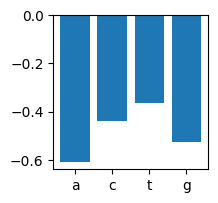

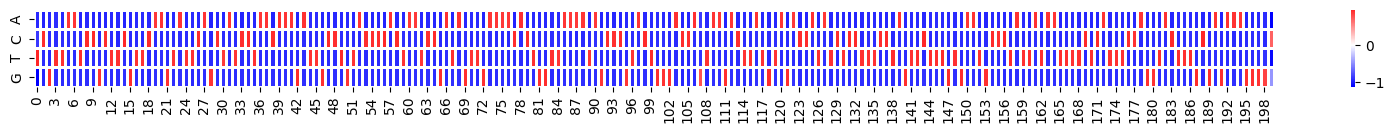

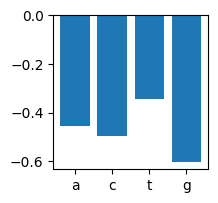

/tmp/ipykernel_33022/1885203364.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(20)): # generating 20*10 sequences


  0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
epochs = 10000
save_and_sample_every = 10
epochs_loss_show = 10 

for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(train_dl):
        x, y = batch
        x = x.type(torch.float32).to(device)
        y = y.type(torch.float32).to(device)
        optimizer.zero_grad()
        #print (batch[0].dtype)
        batch_size = x.shape[0]

        # batch_size = batch["pixel_values"].shape[0]
        # batch = batch["pixel_values"].to(device)


        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long() # sampling a t to generate t and t+1
        #print (t.dtype)



        #loss = p_losses(model, batch, t, loss_type="l2")
        loss = p_losses(model, x, t, y, loss_type="huber")


        loss.backward()
        optimizer.step()
    
    if (epoch % epochs_loss_show) == 0:

        print(f" Epoch {epoch} Loss:", loss.item())

  

    # save generated images
    if epoch != 0 and epoch % save_and_sample_every == 0:
        print ('saving')
        milestone = step // save_and_sample_every
        sample_bs = 2
        sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(sample_bs)))
        random_classes = torch.zeros((sample_bs, len(cell_types)))
        random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()
        
        samples = sample(model, classes=random_classes, image_size=image_size, batch_size=2, channels=1)
        n_print = 0
        for image in samples[-1]:
          if n_print < 4:
            plt.rcParams["figure.figsize"] = (20,1)
            pd_seq = pd.DataFrame(image.reshape(4,200))
            pd_seq.index = nucleotides
            sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0) 
            plt.show()
            plt.rcParams["figure.figsize"] = (2,2)

            plt.bar(['a', 'c', 't', 'g'],pd_seq.mean(1).T)

            plt.show()
            n_print = n_print + 1
        synt_df = sampling_to_metric()
        print(compare_motif_list(synt_df, df_results_seq_guime_count), 'KL' )





  

# Create an diffusion animation

In [ ]:
# sample sequences
samples = sample(model, image_size=image_size, batch_size=10, channels=1)

random_index = 0
!rm image_temp
!mkdir image_temp
fig = plt.figure()
ims = []
for i in range(timesteps):
      plt.rcParams["figure.figsize"] = (20,1)
      pd_seq = pd.DataFrame(samples[i][random_index].reshape(4,200))
      pd_seq.index = nucleotides

      sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
      plt.savefig(f'image_temp/{i}_temp.jpg')
      plt.show()
      plt.clf()

In [ ]:
def make_gif():
    images_to_sort = !ls image_temp -lt
    #print (images_to_sort)
    images_reverse  =[x.split(' ')[-1] for x in images_to_sort][1:]
    images_reverse = images_reverse[::-1]
    
    frames = [Image.open(f'image_temp/{image}') for image in images_reverse]
    #print (len(frames))
    frame_one = frames[0]
    frame_one.save("diff_first.gif", format="GIF", append_images=frames,
               save_all=True, duration=30, loop=0)

In [ ]:
make_gif()